<a href="https://colab.research.google.com/github/hongwai1920/Machine-Learning-algorithms/blob/master/k_nearest_neighbor_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbor (kNN)

This notebook aims to introduce and implement the k-Nearest Neighbor (kNN) image classifier.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this notebook, we will implement these steps and understand the basic Image Classification pipeline and cross-validation.

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys

# import datasets from tensorflow.keras
from tensorflow.keras import datasets

# mount google drive 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# specify path name to import py file
folder_name = 'Colab Notebooks/'
sys.path.append("drive/My Drive/" + folder_name)

# import kNN classifier from py file
from k_nearest_neighbor import KNearestNeighbor

Mounted at /content/drive/


In [0]:
# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [6]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass


# load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# take a peek on dataset
print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

uint8
uint8
uint8
uint8


Observe that the data type of the dataset is uint8 instead of float. 
We need to change to float as data type to avoid calculation error.

In [7]:
# Since pixels are always integer, we change data type to integer
X_train = X_train.astype('int64')
y_train = y_train.astype('int64')
X_test = X_test.astype('int64')
y_test = y_test.astype('int64')

# reshape labels to 1d array
y_train = np.reshape(y_train, (y_train.size))
y_test = np.reshape(y_test, (y_test.size))

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


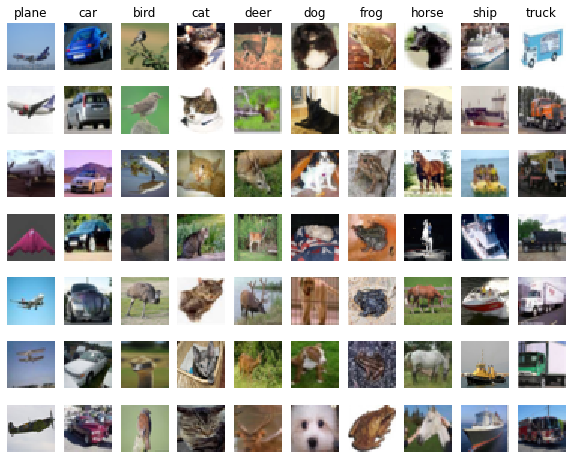

In [8]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [9]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

In [11]:
# compute distances between train set and test set using l2 distance
dists = classifier.compute_distances(X_test)
print(dists.shape)

(500, 5000)


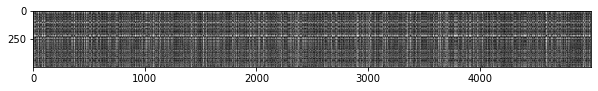

In [12]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show();

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

1. What in the data is the cause behind the distinctly bright rows?
2. What causes the columns?

$\color{blue}{\textit Answer:}$ 

1. Either this is an observation from a class not in the training data set, or is at least very different from all/most of the training data, probably in terms of background color.

2. This training data point doesn’t have any similar points in the test set.


In [13]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


27.4% accuracy.
This is not a very good result.

Now, let's try out a larger `k`, say `k = 5`:

In [14]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


Now, we have a slightly better performance than with `k = 1`.

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.


$\color{blue}{\textit Explanation:}$
1 and 3 do not change the performance of a NN classifier.

This is because Shifting and scaling the whole dataset do not change the nearest neighbors (though their distance might change). 

For 2 and 4, since each  from the dataset is undergoing different shifting and scaling for 

For 5, the only $\ell^p$ norm that is invariant under rotation is $\ell^2$ norm. 
So, if we use $\ell^1$ norm, then rotation will affect the nearest neighbors performance.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [15]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

# Split up the training data into folds. After splitting, X_train_folds and    
# y_train_folds should each be lists of length num_folds, where                
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     
X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


# Perform k-fold cross validation to find the best value of k. For each        
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   
# where in each case you use all but one of the folds as training data and the 
# last fold as a validation set. Store the accuracies for all fold and all     
# values of k in the k_to_accuracies dictionary.                               
for k in k_choices:
  k_to_accuracies[k] = []
  for i in range(num_folds):

    # prepare training data
    X_train_fold = np.concatenate([fold for j, fold in enumerate(X_train_folds) if i != j ])
    y_train_fold = np.concatenate([fold for j, fold in enumerate(y_train_folds) if i != j ])
      
    # train k-nearest-neighbor algorithm
    classifier.train(X_train_fold, y_train_fold)
    y_pred_fold = classifier.predict(X_train_folds[i], k=k)

    # compute correctly predicted labels
    num_correct = np.sum(y_pred_fold == y_train_folds[i])
    accuracy = float(num_correct) / X_train_folds[i].shape[0]
    k_to_accuracies[k].append(accuracy)
  print('k: ', k)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k:  1
k:  3
k:  5
k:  8
k:  10
k:  12
k:  15
k:  20
k:  50
k:  100
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k

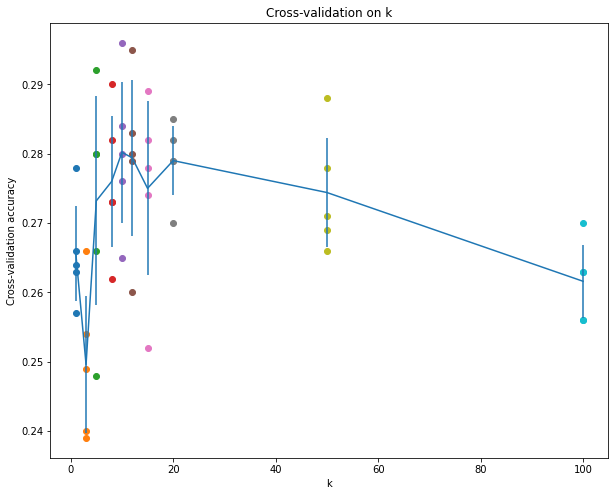

In [16]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [17]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. 
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Explanation:}$
2 and 4

1. [False] The decision boundary of the k-NN classifier is not linear, there is no a hyperplane that separates two classes. For instance, 1-NN decision boundary is the concatenation of segments of a Voronoi tessellation, which partitions the space in convex polygons (Voronoi cells).

2. [True] The training error of a 1-NN will always be better than that of 5-NN because for each training example, its nearest neighbor is always going to be itself, i.e., error of 1-NN is equal to 0.

3. [False] The test error of a 1-NN will not always be better than 5-NN. It will depend on the data we are working with, thus cross validation is a way to determine the best k for the algorithm.

4. [True] Increasing the size of the training dataset incurs large number of comparisons between a test example and all the training dataset. In order to decrease the number of comparisons and time, we can use Approximate Nearest Neighbor techniques such as k-d trees or ball trees.
